<a href="https://colab.research.google.com/github/mtzig/LIDC_GDRO/blob/main/notebooks/lidc_cnn_ERM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ERM CNN Model for Malignancy

#First We setup the repo

In [1]:
# Only run if on Colab
#%cd .. #run this on local machine


!git clone https://github.com/mtzig/LIDC_GDRO.git
%cd /content/LIDC_GDRO

fatal: destination path 'LIDC_GDRO' already exists and is not an empty directory.
/content/LIDC_GDRO


In [2]:
# !git pull

In [3]:
%load_ext autoreload
%autoreload 2

In [7]:
import os
import torch
import pandas as pd
import numpy as np
from dataloaders import InfiniteDataLoader
from datasets import NoduleDataset, SubclassedNoduleDataset
from models import VGGNet, ResNet18
from loss import ERMLoss, GDROLossAlt
# from train import train
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torchvision

In [8]:
import numpy as np
import torch


def train(dataloader, model, loss_fn, optimizer, verbose=False):
    model.train()

    steps_per_epoch = dataloader.batches_per_epoch()

    avg_loss = 0

    for i in range(steps_per_epoch):

        loss = loss_fn(next(dataloader))
        avg_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss /= steps_per_epoch

    if verbose:
        print("Average training loss:", avg_loss)

In [9]:
if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Using cpu")
    DEVICE = torch.device("cpu")

Good to go!


#Test Models

In [68]:
import torch.nn as nn

class testModel(nn.Module):

    def __init__(self, device='cpu', pretrained=True, freeze=True):
        super(testModel, self).__init__()

        self.model = torchvision.models.resnet18(pretrained=pretrained).to(device) #torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True).to(device)
        
        # if pretrained and freeze:
        #     for param in self.model.parameters():
        #         param.requires_grad = False


        #     for param in self.model.layer4.parameters():
        #         param.requires_grad = True

        self.model.fc = nn.Sequential(
          nn.Linear(in_features=512, out_features=50, bias=True, device=device),
          nn.ReLU(inplace=True),
          nn.Dropout(p=0.5, inplace=False),
          nn.Linear(in_features=50, out_features=2, bias=True, device=device)
          # nn.Linear(in_features=36, out_features=1, bias=True, device=device)
        )

        for layer in self.model.fc:
            if hasattr(layer, 'weight'):
                nn.init.xavier_uniform_(layer.weight)

    def forward(self, x):
        return self.model(x).squeeze()


#Next We get our data

## First some functions to retrive the data

In [11]:
def getNormed(this_array, this_min = 0, this_max = 255, set_to_int = True):
    
    rat = (this_max - this_min)/(this_array.max() - this_array.min())
    this_array = this_array * rat
    this_array -= this_array.min()
    this_array += this_min
    if set_to_int:
        return this_array.to(dtype= torch.int)
    return this_array

In [80]:
def getImages(image_folder):
    '''
        Input:
        image_folder: directory of the image files

        Output:
        m1: list of the labels encountered (1,2,4,5)
        m2: list of binary labels encountered (benign, malignant)
        diff: list of any nodes with discrepency to CSV labels

    '''
    upscale = torchvision.transforms.Resize(71)

    train_img = []
    train_label = []
    train_subclasses = []

    marked_benign = []
    unmarked_benign = []
    
    marked_malignant = []
    unmarked_malignant = []

    

    lidc = pd.read_csv('./data/lidc_spic_subgrouped.csv')
    train_test = pd.read_csv('./data/lidc_train_test_split_stratified.csv')
    for dir1 in os.listdir(image_folder):
  
        if dir1 == 'Malignancy_3':
            continue

        for file in os.listdir(os.path.join(image_folder, dir1)):


            temp_nodule_ID = file.split('.')[0]
            subtype = lidc[lidc['noduleID']==int(temp_nodule_ID)]['subgroup'].iloc[0]
            malignancy = lidc[lidc['noduleID']==int(temp_nodule_ID)]['malignancy'].iloc[0]
            spiculation = lidc[lidc['noduleID']==int(temp_nodule_ID)]['malignancy'].iloc[0]
            
            train_type = train_test[train_test['noduleID'] ==int(temp_nodule_ID)]['dataset'].iloc[0]
            
            
            image = np.loadtxt(os.path.join(image_folder, dir1,file))
            image = torch.from_numpy(image).to(DEVICE)
            

            
            # rgb_image = torch.stack((image,image,image), dim = 0)
            # rgb_image = getNormed(rgb_image)
            rgb_image = getNormed(image)
            rgb_image = rgb_image / 255

            img_ch1 = rgb_image.unsqueeze(dim=0)
            img_ch2 = upscale(rgb_image[15:56,15:56].unsqueeze(dim=0))
            img_ch3 = upscale(rgb_image[25:46,25:46].unsqueeze(dim=0))
            # rgb_image = rgb_image#[:,15:56, 15:56]
            rgb_image = torch.cat([img_ch1,img_ch2,img_ch3])

            rgb_image_90 = torchvision.transforms.functional.rotate(rgb_image, 90)
            rgb_image_180 = torchvision.transforms.functional.rotate(rgb_image, 180)
            rgb_image_270 = torchvision.transforms.functional.rotate(rgb_image, 270)

            rgb_image_f = torch.flip(rgb_image, [0,1])
            rgb_image_90_f = torch.flip(rgb_image_90, [0,1])
            rgb_image_180_f = torch.flip(rgb_image_180, [0,1])
            rgb_image_270_f = torch.flip(rgb_image_270, [0,1])
            #rgb_image = upscale(rgb_image)

            
            
            if train_type == 'train':
                train_img.append(rgb_image)
                train_img.append(rgb_image_90)
                train_img.append(rgb_image_180)
                train_img.append(rgb_image_270)

                train_img.append(rgb_image_f)
                train_img.append(rgb_image_90_f)
                train_img.append(rgb_image_180_f)
                train_img.append(rgb_image_270_f)
                # train_label.append(torch.tensor(1).to(DEVICE).to(torch.float32) if malignancy > 3 else torch.tensor(0).to(DEVICE).to(torch.float32))
                # train_label.append(torch.tensor(0.25 * (malignancy-1)).to(DEVICE).to(torch.float32)) 
                train_label.extend([torch.tensor(1).to(DEVICE) if malignancy > 3 else torch.tensor(0).to(DEVICE)]*8)

                if subtype == 'marked_benign':
                  train_subclasses.extend([torch.tensor(0).to(DEVICE)]*8)
                elif subtype == 'unmarked_benign':
                  train_subclasses.extend([torch.tensor(1).to(DEVICE)]*8)
                elif subtype == 'marked_malignant':
                  train_subclasses.extend([torch.tensor(2).to(DEVICE)]*8)
                else:
                  train_subclasses.extend([torch.tensor(3).to(DEVICE)]*8)


                
                continue
            
            if subtype == 'marked_benign':
                image_array = marked_benign
            elif subtype == 'unmarked_benign':
                image_array = unmarked_benign
            elif subtype == 'marked_malignant':
                image_array = marked_malignant
            else:
                image_array = unmarked_malignant
            
            image_array.append(rgb_image)
 


    return train_img, train_label, train_subclasses, marked_benign, unmarked_benign, marked_malignant, unmarked_malignant

## Now we get the data

In [81]:
train_img, train_label, train_subclasses, marked_benign, unmarked_benign, marked_malignant, unmarked_malignant = getImages('./LIDC(MaxSlices)_Nodules(fixed)')

In [82]:
# train_dataset_spic = NoduleDataset(train_img, train_spic_label)
train_dataset = SubclassedNoduleDataset(train_img, train_label, train_subclasses)

In [83]:
len(train_subclasses)

9680

In [90]:
train_set, val_set = torch.utils.data.random_split(train_dataset, [9280, 400])
# train_spic_set, val_spic_set = torch.utils.data.random_split(train_dataset_spic, [1000, 210])

# train_spic_loader = InfiniteDataLoader(train_spic_set, 128)
# val_spic_loader = InfiniteDataLoader(val_spic_set, len(val_spic_set))

train_loader = InfiniteDataLoader(train_set, 256) #200 epochs
val_loader = InfiniteDataLoader(val_set, len(val_set))

# train_loader = InfiniteDataLoader(train_set, 128)

#Now we create the model and setup training

First we make our model

In [91]:
model = testModel(device=DEVICE, pretrained=True, freeze=False)

In [92]:
loss_fn = ERMLoss(model,torch.nn.CrossEntropyLoss(),{}, subclassed=True)
# loss_fn = GDROLossAlt(model,torch.nn.CrossEntropyLoss(),0.1, 4) 

# loss_fn = ERMLoss(model,torch.nn.functional.binary_cross_entropy_with_logits,{})
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.005)#lr=0.001, weight_decay=0.005)


We also make learning rate scheduler

In [93]:
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=2, verbose=True)

##Now we train the model

In [94]:
epochs = 10#40

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # train(train_spic_loader, model, loss_fn, optimizer, verbose=True)
    train(train_loader, model, loss_fn, optimizer, verbose=True)
    model.eval()
    with torch.no_grad():
      # X,y = next(val_spic_loader)
      X,y, _ = next(val_loader)
      logits = model(X)
      # results = torch.sigmoid(logits)
      results = torch.max(logits, dim=1)[1]
      # accuracy = torch.sum(torch.round(results) == y)/X.shape[0]
      accuracy = torch.sum(results == y)/X.shape[0]

    print(f'cv accuracy {accuracy}')
    scheduler.step(accuracy)

Epoch 1/10
Average training loss: 0.5182648127277693
cv accuracy 0.8050000071525574
Epoch 2/10
Average training loss: 0.3077990470661057
cv accuracy 0.824999988079071
Epoch 3/10
Average training loss: 0.245260841316647
cv accuracy 0.8324999809265137
Epoch 4/10
Average training loss: 0.21623896973000634
cv accuracy 0.79749995470047
Epoch 5/10
Average training loss: 0.1624099678463406
cv accuracy 0.8324999809265137
Epoch 6/10
Average training loss: 0.13801882146961159
cv accuracy 0.8100000023841858
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
Epoch 7/10
Average training loss: 0.07511032129534417
cv accuracy 0.8474999666213989
Epoch 8/10
Average training loss: 0.03095843822747055
cv accuracy 0.85999995470047
Epoch 9/10
Average training loss: 0.017978696695839364
cv accuracy 0.8700000047683716
Epoch 10/10
Average training loss: 0.012380830898311816
cv accuracy 0.8924999833106995


#Lastly We evaluate model performance

We first create a simple function to get sensitivities

In [73]:
def get_sensitivity(model, imgs, label, label_tensor = False):
  '''
  Inputs:
  model: the model to use
  img: list of imgs in the class
  label: either 0 or 1 depending on the ground truth of subclass
  label_tensor: if True, then label is tensor of ground truth

  Output:
  accuracy: accuracy for this subgroup

  '''
  # results = torch.sigmoid(model(torch.stack(imgs).to(DEVICE)))
  results = torch.max(model(torch.stack(imgs).to(DEVICE)),dim=1)[1]
  if label_tensor:
    truth = label
  elif label == 1:
    truth = torch.ones(len(imgs), device=DEVICE)
  else:
    truth = torch.zeros(len(imgs), device=DEVICE)
  
  # accuracy = torch.sum(torch.round(results) == truth)/len(imgs)
  accuracy = torch.sum(results == truth)/len(imgs)

  return accuracy

##Model Performance on Test Set

In [95]:
#spaghetti code-esque way to get imgs and labels for entire test set
all_test_imgs = marked_benign+unmarked_benign+marked_malignant+unmarked_malignant
all_labels = torch.tensor([0 for _ in marked_benign+unmarked_benign]+[1 for _ in marked_malignant+unmarked_malignant], device=DEVICE)


print(f'spiculated benign accuracy: {get_sensitivity(model, marked_benign, 0):.3f}')
print(f'unspiculated benign accuracy: {get_sensitivity(model, unmarked_benign, 0):.3f}')
print(f'spiculated malignant accuracy: {get_sensitivity(model, marked_malignant, 1):.3f}')
print(f'unspiculated malignant accuracy: {get_sensitivity(model, unmarked_malignant, 1):.3f}')

print(f'Total accuracy: {get_sensitivity(model, all_test_imgs, all_labels, label_tensor=True):.3f}')

spiculated benign accuracy: 0.762
unspiculated benign accuracy: 0.869
spiculated malignant accuracy: 0.841
unspiculated malignant accuracy: 0.667
Total accuracy: 0.816


# Run of 30 test

In [96]:
accuracies = []
for run in range(1,31):
  model = testModel(device=DEVICE, pretrained=True, freeze=False)
  loss_fn = ERMLoss(model,torch.nn.CrossEntropyLoss(),{}, subclassed=True) #torch.nn.functional.binary_cross_entropy_with_logits
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.005)#lr=0.001, weight_decay=0.005)
  scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=2, verbose=True)

  epochs = 10

  for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # train(train_spic_loader, model, loss_fn, optimizer, verbose=True)
    train(train_loader, model, loss_fn, optimizer, verbose=True)

    model.eval()
    with torch.no_grad():
      # X,y = next(val_spic_loader)
      X,y, _ = next(val_loader)
      logits = model(X)
      # results = torch.sigmoid(logits)
      results = torch.max(logits, dim=1)[1]
      # accuracy = torch.sum(torch.round(results) == y)/X.shape[0]
      accuracy = torch.sum(results == y)/X.shape[0]

    print(f'cv accuracy {accuracy}')
    scheduler.step(accuracy)

  all_test_imgs = marked_benign+unmarked_benign+marked_malignant+unmarked_malignant
  all_labels = torch.tensor([0 for _ in marked_benign+unmarked_benign]+[1 for _ in marked_malignant+unmarked_malignant], device=DEVICE)


  print(f'spiculated benign accuracy: {get_sensitivity(model, marked_benign, 0):.3f}')
  print(f'unspiculated benign accuracy: {get_sensitivity(model, unmarked_benign, 0):.3f}')
  print(f'spiculated malignant accuracy: {get_sensitivity(model, marked_malignant, 1):.3f}')
  print(f'unspiculated malignant accuracy: {get_sensitivity(model, unmarked_malignant, 1):.3f}')

  print(f'Total accuracy: {get_sensitivity(model, all_test_imgs, all_labels, label_tensor=True):.3f}')
  accuracies.append((get_sensitivity(model, marked_benign, 0),
                     get_sensitivity(model, unmarked_benign, 0),
                     get_sensitivity(model, marked_malignant, 1),
                     get_sensitivity(model, unmarked_malignant, 1),
                     get_sensitivity(model, all_test_imgs, all_labels, label_tensor=True)))

Epoch 1/10


KeyboardInterrupt: ignored

In [47]:
total_acc = list(map(lambda x:x[-1], accuracies))

In [48]:
sum(total_acc)/len(total_acc)

tensor(0.8197, device='cuda:0')

In [49]:
accuracies = list(map(lambda x:(float(i) for i in x), accuracies))

In [50]:
df = pd.DataFrame(accuracies, columns = ['marked_benign', 'unmarked_benign', 'marked_malignant', 'unmarked_malignant', 'entire'])

In [51]:
df.head()

,marked_benign,unmarked_benign,marked_malignant,unmarked_malignant,entire
0,0.761905,0.910345,0.804878,0.631579,0.819672
1,0.666667,0.848276,0.853658,0.771930,0.822951
2,0.619048,0.827586,0.890244,0.701754,0.806557
3,0.952381,0.882759,0.841463,0.666667,0.836066
4,0.857143,0.875862,0.817073,0.578947,0.803279


In [52]:
df.to_csv('cnn_erm_accuracies.csv')

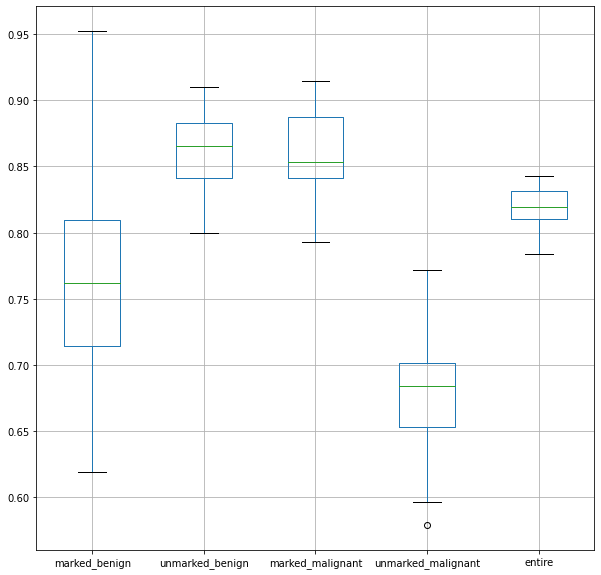

In [53]:
boxplot = df.boxplot(column=['marked_benign', 'unmarked_benign', 'marked_malignant', 'unmarked_malignant', 'entire'], figsize = (10,10))  

#GDRO Model Performance

In [54]:
accuracies = []
for run in range(1,31):
  model = testModel(device=DEVICE, pretrained=True, freeze=False)
  loss_fn = GDROLossAlt(model,torch.nn.CrossEntropyLoss(),0.1,4) #torch.nn.functional.binary_cross_entropy_with_logits
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.005)#lr=0.001, weight_decay=0.005)
  scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=2, verbose=True)

  epochs = 10

  for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # train(train_spic_loader, model, loss_fn, optimizer, verbose=True)
    train(train_loader, model, loss_fn, optimizer, verbose=True)

    model.eval()
    with torch.no_grad():
      # X,y = next(val_spic_loader)
      X,y, _ = next(val_loader)
      logits = model(X)
      # results = torch.sigmoid(logits)
      results = torch.max(logits, dim=1)[1]
      # accuracy = torch.sum(torch.round(results) == y)/X.shape[0]
      accuracy = torch.sum(results == y)/X.shape[0]

    print(f'cv accuracy {accuracy}')
    scheduler.step(accuracy)

  all_test_imgs = marked_benign+unmarked_benign+marked_malignant+unmarked_malignant
  all_labels = torch.tensor([0 for _ in marked_benign+unmarked_benign]+[1 for _ in marked_malignant+unmarked_malignant], device=DEVICE)


  print(f'spiculated benign accuracy: {get_sensitivity(model, marked_benign, 0):.3f}')
  print(f'unspiculated benign accuracy: {get_sensitivity(model, unmarked_benign, 0):.3f}')
  print(f'spiculated malignant accuracy: {get_sensitivity(model, marked_malignant, 1):.3f}')
  print(f'unspiculated malignant accuracy: {get_sensitivity(model, unmarked_malignant, 1):.3f}')

  print(f'Total accuracy: {get_sensitivity(model, all_test_imgs, all_labels, label_tensor=True):.3f}')
  accuracies.append((get_sensitivity(model, marked_benign, 0),
                     get_sensitivity(model, unmarked_benign, 0),
                     get_sensitivity(model, marked_malignant, 1),
                     get_sensitivity(model, unmarked_malignant, 1),
                     get_sensitivity(model, all_test_imgs, all_labels, label_tensor=True)))

Epoch 1/10
Average training loss: 0.8027241321073638
cv accuracy 0.7849999666213989
Epoch 2/10
Average training loss: 0.4776615434222751
cv accuracy 0.7849999666213989
Epoch 3/10
Average training loss: 0.43139661931329304
cv accuracy 0.8349999785423279
Epoch 4/10
Average training loss: 0.3527814360956351
cv accuracy 0.73499995470047
Epoch 5/10
Average training loss: 0.268020112067461
cv accuracy 0.7899999618530273
Epoch 6/10
Average training loss: 0.2287325436870257
cv accuracy 0.7599999904632568
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
Epoch 7/10
Average training loss: 0.13656924354533354
cv accuracy 0.8499999642372131
Epoch 8/10
Average training loss: 0.10068017730696334
cv accuracy 0.85999995470047
Epoch 9/10
Average training loss: 0.07067791372537613
cv accuracy 0.7849999666213989
Epoch 10/10
Average training loss: 0.046507398313325315
cv accuracy 0.8100000023841858
spiculated benign accuracy: 0.857
unspiculated benign accuracy: 0.869
spiculated malignant accur

In [56]:
total_acc = list(map(lambda x:x[-1], accuracies))
sum(total_acc)/len(total_acc)

tensor(0.8121, device='cuda:0')

In [57]:
accuracies = list(map(lambda x:(float(i) for i in x), accuracies))

In [58]:
df = pd.DataFrame(accuracies, columns = ['marked_benign', 'unmarked_benign', 'marked_malignant', 'unmarked_malignant', 'entire'])

In [59]:
df.head()

,marked_benign,unmarked_benign,marked_malignant,unmarked_malignant,entire
0,0.857143,0.868966,0.817073,0.754386,0.832787
1,0.809524,0.862069,0.878049,0.701754,0.832787
2,0.809524,0.841379,0.829268,0.719298,0.813115
3,0.809524,0.889655,0.841463,0.701754,0.836066
4,0.666667,0.848276,0.841463,0.631579,0.793443


In [60]:
df.to_csv('cnn_gdro_accuracies.csv')

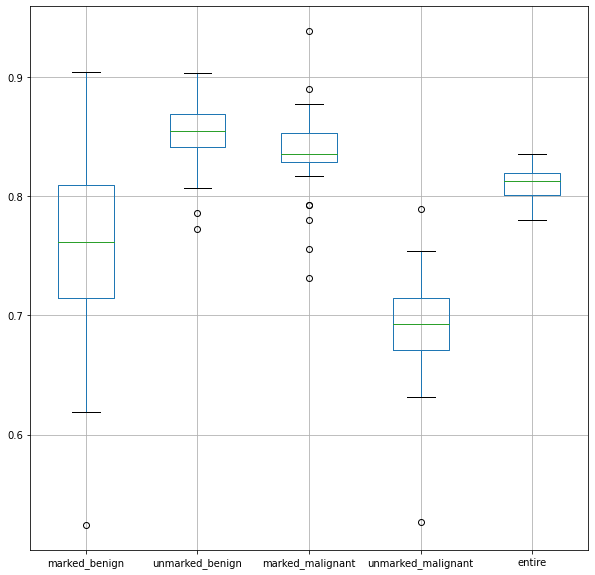

In [61]:
boxplot = df.boxplot(column=['marked_benign', 'unmarked_benign', 'marked_malignant', 'unmarked_malignant', 'entire'], figsize = (10,10))  